In [1]:
import numpy as np
from src.tests.wrapper_stack import StackWrapper
from src.var_processor.pb_threshold import signal_pre_processor

/home/ben/projects/var_processor/src/var_processor/power_iterator.py:18: RuntimeWarning: invalid value encountered in floor_divide
  scaled_array = (np.abs(array)*127//sq_root_sum)*signs


80.04296875


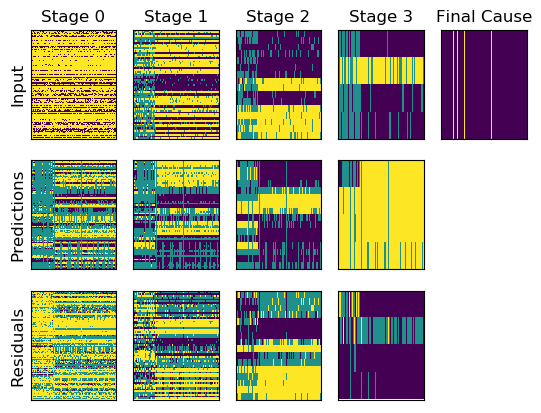

In [2]:
buf_length = 500
sen_length = 256
vec_len = 4
wrapper = StackWrapper(sen_length, vec_len, buf_length=buf_length)

# Generate fake data
data_in = np.random.randint(254, size=(sen_length, 1), dtype=np.uint8)
mean = np.asarray([127]*sen_length, dtype=np.uint8).reshape(-1, 1)

for i in range(0, buf_length):
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    wrapper.iterate(input_signal)
error, mse = wrapper.error(data_in, mean)
print(mse)
wrapper.plot_buffers()

In [3]:
buf_length = 500
sen_length = 256
vec_len = 4

# Create a set of wrappers for multiple stacks
wrappers = [
    StackWrapper(sen_length, vec_len, buf_length=buf_length)
    for i in range(0, vec_len)
]

mean = np.asarray([127]*sen_length, dtype=np.uint8).reshape(-1, 1)

for i in range(0, buf_length):
    # Generate fake data
    data_in = np.random.randint(254, size=(sen_length, 1), dtype=np.uint8)
    # Iterate over stacks
    input_signal = signal_pre_processor(data_in, mean)
    for wrapper in wrappers:
        _, _, residual = wrapper.iterate(input_signal)
        input_signal = residual

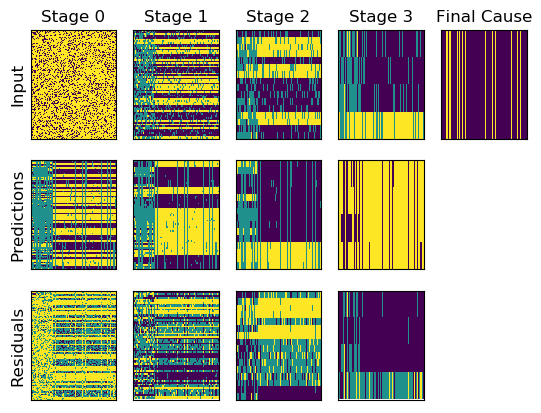

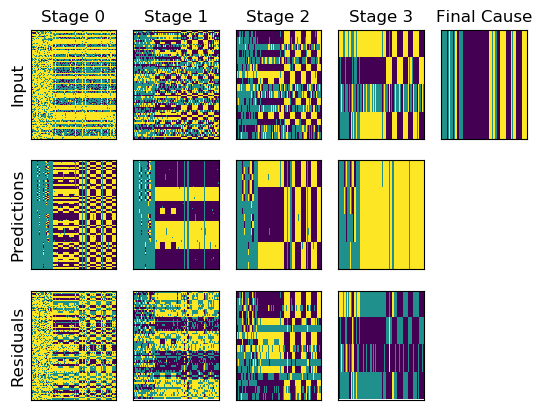

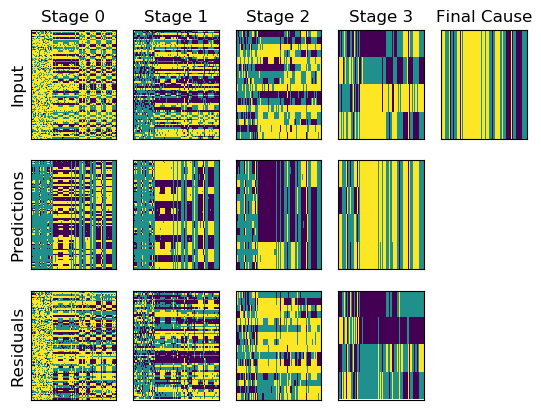

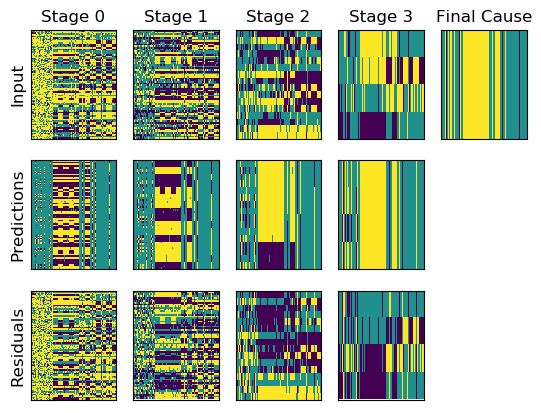

In [4]:
%matplotlib inline
for wrapper in wrappers:
    wrapper.plot_buffers()

One thing to remember in the above is that we are looking at the binary signals - if we reconstruct an original real input we may get close.

We are getting a zero eigenvector somewhere - it looks like in the fourth stage. But shouldn't our logic prevent this?

We need a way to visualise the eigenvectors...
* Each stage will have a set of eigenvectors from the VPU - we could have as a long array separated by zeros to space. Then we could plot as a bar chart.

In [5]:
for stage in wrappers[0].stack.get_eigenvectors():
    print(len(stage))

64
16
4
1


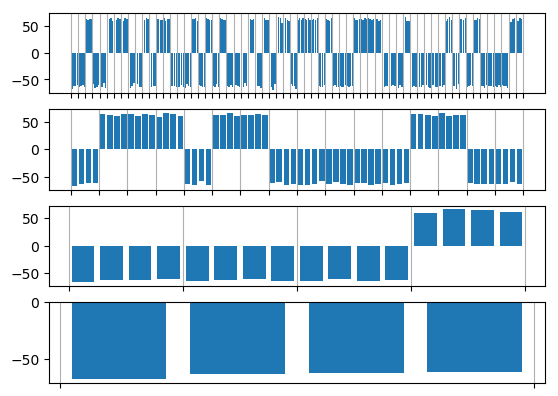

In [6]:
wrappers[0].plot_eigenvectors()

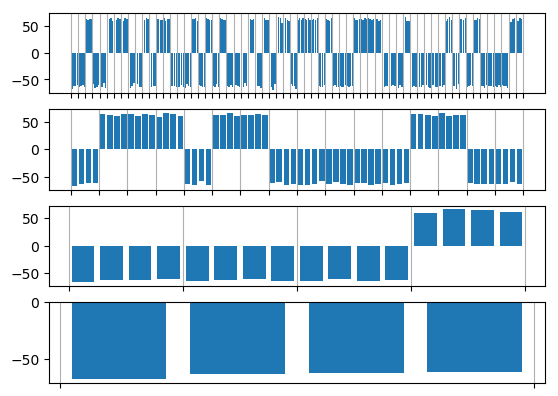

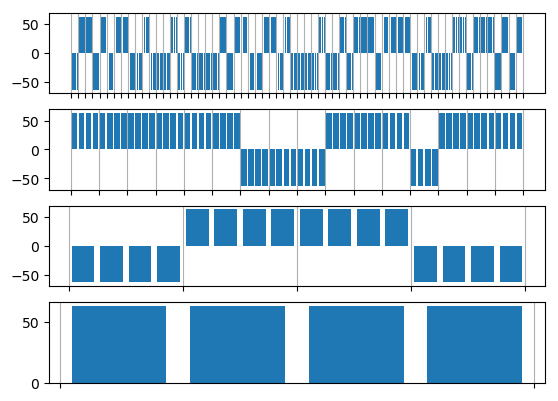

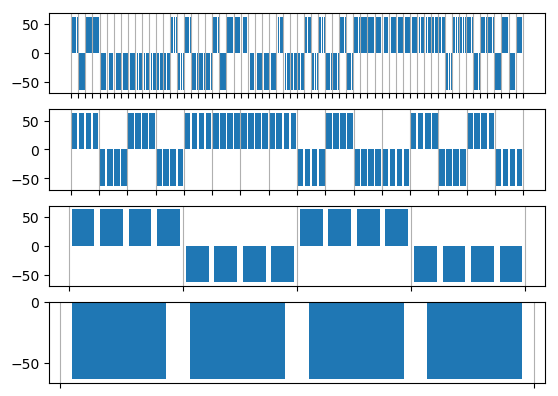

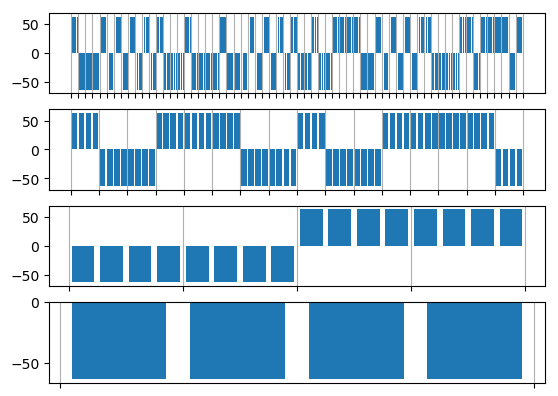

In [9]:
for wrapper in wrappers:
    wrapper.plot_eigenvectors()

In [7]:
wrapper = wrappers[0]
spacer_len = 0
spacer = np.zeros(spacer_len)
evs = wrapper.stack.get_eigenvectors()
# Define result arrays with extra spacing
result_arrays = [np.zeros((wrapper.vec_len+spacer_len)*len(stage)) for stage in evs]
for result_array, stage_vpus in zip(result_arrays, evs):
    i = 0
    for vpu in stage_vpus:
        result_array[i:i+wrapper.vec_len] = vpu.ravel()
        i += wrapper.vec_len+spacer_len

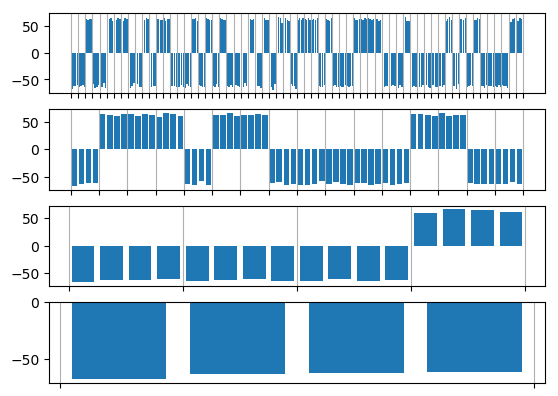

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(evs), 1)
for ax, result_array in zip(axes, result_arrays):
    ax.bar(np.arange(0, result_array.shape[0]), result_array)
    ax.set_xticks(np.arange(-0.5, result_array.shape[0], wrapper.vec_len+spacer_len))
    ax.xaxis.grid(True)
    ax.set_xticklabels([])
plt.show()